MVPA analysis: Preprocessing and quality control

`
Authors:
Egor Ananyev
Jit Wei Ang Aaron
`

`
Based on the code by:
Alexandre Gramfort
Denis A. Engemann
`

# Preparation

## Loading packages

In [1]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
import os

In [2]:
mne.set_log_level('warning')  # less verbose output

## Setting parameters

In [3]:
interactive = False  # Whether to render interactive figures such as channel plots
# ...should be set to True on first pass

debug = False

cur_subj = 1
cur_run = 7

filt_low = 0
filt_high = 80

epoch_beg_s = -0.3
epoch_end_s =  0.6
baseline = (-0.2, 0)

## Define peak-to-peak (amplitude range) rejection parameters for gradiometers, magnetometers and EOG:
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)  # this can be highly data dependent

## Accessing raw data

In [4]:
# data_path = os.path.expanduser("C:\\Users\\egora\\Downloads\\meg\\")
data_path = os.path.expanduser('E:\\meg\\')

cur_subj_str = str(cur_subj).zfill(2)
cur_run_str = str(cur_run).zfill(2)

raw_fname = os.path.join(data_path,
                         'derivatives\\meg_derivatives\\sub-' + cur_subj_str + '\\ses-meg\\meg\\sub-' + \
                         cur_subj_str + '_ses-meg_experimental_run-' + cur_run_str + '_proc-sss_raw.fif')

In [5]:
qc_path = os.path.join(data_path, 'derivatives\\meg_derivatives\\sub-' + cur_subj_str + '\\ses-meg\\meg-qc\\')
qc_fname = os.path.join(qc_path, 'sub-' + cur_subj_str + '_run-' + cur_run_str)

In [6]:
print(raw_fname)

E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-07_proc-sss_raw.fif


In [7]:
ls $raw_fname

 Volume in drive E is Elements
 Volume Serial Number is 7C5D-1710

 Directory of E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg

2020-02-05  16:20       359,565,296 sub-01_ses-meg_experimental_run-07_proc-sss_raw.fif
               1 File(s)    359,565,296 bytes
               0 Dir(s)  2,991,814,819,840 bytes free


Read data from file:

In [8]:
raw = mne.io.read_raw_fif(raw_fname, preload=False)
print(raw)

<Raw  |  sub-01_ses-meg_experimental_run-07_proc-sss_raw.fif, n_channels x n_times : 327 x 271000 (271.0 sec), ~5.5 MB, data not loaded>


In [9]:
print(raw.info)

<Info | 28 non-empty fields
    acq_pars : str | 25272 items
    bads : list | 0 items
    ch_names : list | EOG001, EOG002, ECG003, MEG0111, MEG0112, MEG0113, ...
    chs : list | 327 items (EOG: 2, ECG: 1, MAG: 102, GRAD: 204, MISC: 1, STIM: 7, SYST: 1, CHPI: 9)
    comps : list | 0 items
    custom_ref_applied : bool | False
    description : str | 34 items
    dev_head_t : Transform | 3 items
    dig : Digitization | 149 items (3 Cardinal, 4 HPI, 142 Extra)
    events : list | 1 items
    experimenter : str | 17 items
    file_id : dict | 4 items
    gantry_angle : float | 68.0
    highpass : float | 0.10000000149011612 Hz
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    hpi_subsystem : dict | 2 items
    line_freq : float | 50.0
    lowpass : float | 330.0 Hz
    meas_date : tuple | 2020-02-05 07:58:40 GMT
    meas_id : dict | 4 items
    nchan : int | 327
    proc_history : list | 1 items
    proj_id : ndarray | 1 items
    proj_name : str | 24 items
    projs :

In [10]:
raw.info['sfreq']  # Sampling frequency

1000.0

In [11]:
raw.info['line_freq']

50.0

The powerline frequency. 50 Hz in Sg; 60 Hz in Taiwan.

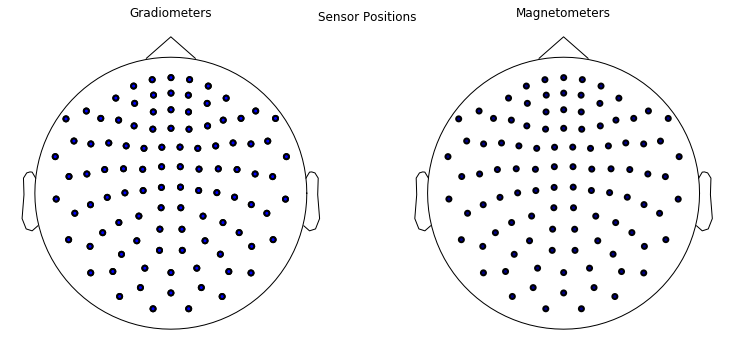

In [12]:
%matplotlib inline
fig, (left, right) = plt.subplots(ncols=2, figsize=(10, 5))
raw.plot_sensors(kind='topomap', ch_type='grad', axes=left, show=False);
left.set_title('Gradiometers')
raw.plot_sensors(kind='topomap', ch_type='mag', axes=right, show=False);
right.set_title('Magnetometers')
fig.suptitle('Sensor Positions');
# plt.savefig(qc_fname + '_sensor-positions.pdf')

## Examining raw data

<div class="alert alert-success">
    <b>Checklist</b>:
     <ul>
    <li>Missing data</li>
    <li>Noisy channels</li>
    </ul>
</div>

In [13]:
%matplotlib qt
if interactive:
    raw.plot()

# Timing correction

## Light sensor data

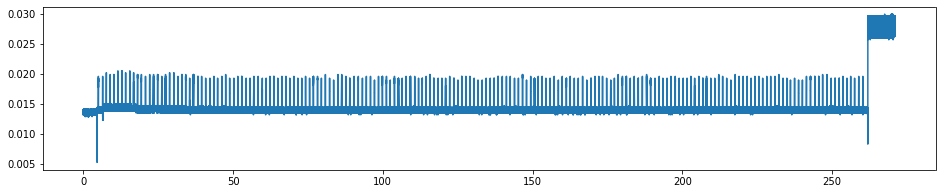

In [14]:
%matplotlib inline
light_sensor = raw.get_data(picks='MISC001')
plt.figure(figsize=(16, 3))
plt.plot(raw.times, light_sensor.T);
# plt.savefig(qc_fname + '_light-sensors.pdf')

In [15]:
print('min ~ ' + '{0:.3f}'.format(np.min(light_sensor)))
print('max ~ ' + '{0:.3f}'.format(np.max(light_sensor)))

min ~ 0.005
max ~ 0.030


Based on the above, a light threshold of ~ 0.016 sounds reasonable:

In [16]:
light_thresh = 0.016
too_bright = 0.025
light_sensor_thresholded = light_sensor
light_sensor_thresholded[light_sensor > too_bright] = 0  # this deals with the initial and final non-exptal period
light_sensor_thresholded[light_sensor < light_thresh] = 0
light_sensor_thresholded[light_sensor >= light_thresh] = 1
plt.figure(figsize=(16, 3))
# plt.plot(raw.times, light_sensor_thresholded.T);

<Figure size 1152x216 with 0 Axes>

<Figure size 1152x216 with 0 Axes>

## Example data before correction

In [17]:
# Taking an excerpt from the data from 245 to 250 s:
start, stop = int(245 * raw.info['sfreq']), int(250 * raw.info['sfreq'])
data_excerpt, times = raw[:, start:stop]  # fetch all channels and the first 10 time points
print(data_excerpt.shape)  # should be 5000 samples at sfreq = 1000 Hz
print(times.shape)

(327, 5000)
(5000,)


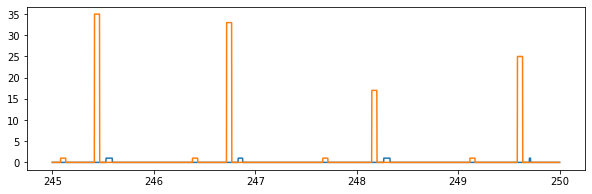

In [18]:
plt.figure(figsize=(10,3))
plt.plot(raw.times[start:stop], light_sensor_thresholded.T[start:stop])
trigger_channel_excerpt = raw.get_data(picks='STI101', start=start, stop=stop) - 2048
plt.plot(raw.times[start:stop], trigger_channel_excerpt.T);

## Preparing the timing correction

Instead of applying timing correction per se, I modify the light sensor channel (MISC001) to carry trigger information and use this instead of STI101.

In [19]:
trigger_channel = raw.get_data(picks='STI101') - 2048
trigger_channel[trigger_channel == 1] = 0
start = 0
stop = len(trigger_channel[0])
print('Taking samples ' + str(start) + ' to ' + str(stop))

Taking samples 0 to 271000


In [20]:
# number of trials is the number of triggers == 1, but for now, I'll hardcode:
numof_trials = 192

## Logic of light-sensor indexing

This is just a demonstration of how the light sensor timestamps are identified.

In [21]:
new_start = np.min(np.where(light_sensor_thresholded[0, :] == 1))
print('the first instance of light sensor above threshold: ' + str(new_start))

the first instance of light sensor above threshold: 5012


In [22]:
print('thresh light value prior to blip start = ' + str(light_sensor_thresholded[0, new_start-1]))
print('thresh light value at blip start = ' + str(light_sensor_thresholded[0, new_start]))

thresh light value prior to blip start = 0.0
thresh light value at blip start = 1.0


In [23]:
blip_dur = np.min(np.where(light_sensor_thresholded[0, new_start:stop] == 0))
print(blip_dur)  # duration of the light sensory == 1 blip

62


In [24]:
print('thresh light value prior to blip end = ' + str(light_sensor_thresholded[0, new_start+blip_dur-1]))
print('thresh light value at blip start = ' + str(light_sensor_thresholded[0, new_start+blip_dur]))

thresh light value prior to blip end = 1.0
thresh light value at blip start = 0.0


## Finding and comparing timestamps

In [25]:
trigger_samples = pd.DataFrame(data = {'STI_sample': np.repeat(0, numof_trials),
                                       'STI_trigger': np.repeat(0, numof_trials),
                                       'LS_sample': np.repeat(0, numof_trials),
                                       'LS_dur': np.repeat(0, numof_trials),
                                       'sample_mismatch': np.repeat(0, numof_trials)})
# print(trigger_samples)

In [26]:
start = 0
cur_trial = 1
stim_sample = start + np.min(np.where(trigger_channel[0, start:stop] > 0))
print(stim_sample)
print(trigger_channel[0, stim_sample])

4912
35.0


In [27]:
import copy

In [28]:
start = 0
light_sensor_recoded = copy.copy(light_sensor_thresholded)
for cur_trial in range(numof_trials):
    # Getting the stimulus trigger time stamp: this is where the search starts
    stim_sample = start + np.min(np.where(trigger_channel[0, start:stop] > 0))
    trigger_samples.at[cur_trial, 'STI_sample'] = stim_sample
    # Getting the stimulus trigger value: this is the value to which the light channel is reassigned:
    stim_val = trigger_channel[0, stim_sample]
    trigger_samples.at[cur_trial, 'STI_trigger'] = stim_val
    # Getting the light sensor time stamp and duration:
    light_sample = start + np.min(np.where(light_sensor_thresholded[0, start:stop] == 1))
    trigger_samples.at[cur_trial, 'LS_sample'] = light_sample
    blip_dur = np.min(np.where(light_sensor_thresholded[0, light_sample:stop] == 0))
    trigger_samples.at[cur_trial, 'LS_dur'] = blip_dur
    # Recording the mismatch between the stim trigger and light sensor time stamps:
    trigger_samples.at[cur_trial, 'sample_mismatch'] = light_sample - stim_sample
    # Assigning a new start time stamp for the search in the next trial in the loop:
    start = light_sample + blip_dur + 1
    # Assigning the trigger value to the light sensor time stamp (in lieu of temp correction):
    light_sensor_recoded[0, light_sample:start] = stim_val  # note that this is the 'new' start
    if debug:
        print('=============================================')
        print('stim_sample = ' + str(stim_sample))
        print('stim_trigger_val = ' + str(stim_val))
        print('light_sample = ' + str(light_sample))
        print('blip_dur = ' + str(blip_dur))
        print('mismatch = ' + str(light_sample - stim_sample))
        print(start)

In [29]:
print(trigger_samples)  # STI = stimulus channel; LS = light sensor channel

     STI_sample  STI_trigger  LS_sample  LS_dur  sample_mismatch
0          4912           35       5012      62              100
1          6330           29       6447      28              117
2          7562            6       7681      30              119
3          8861           24       8966      13              105
4         10095           26      10201      29              106
..          ...          ...        ...     ...              ...
187      254832           30     254942      45              110
188      256100            9     256210      28              110
189      257399           26     257512      28              113
190      258749           14     258863      62              114
191      260117           37     260232      62              115

[192 rows x 5 columns]


## Video output delay

In [30]:
mismatch_range = np.max(trigger_samples['sample_mismatch']) - np.min(trigger_samples['sample_mismatch'])
print(mismatch_range)

21


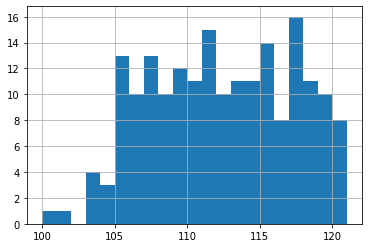

In [31]:
trigger_samples['sample_mismatch'].hist(bins=mismatch_range);
# plt.savefig(qc_fname + '_delay.pdf')

In [32]:
trigger_samples['sample_mismatch'].describe()

count    192.000000
mean     111.890625
std        4.908963
min      100.000000
25%      108.000000
50%      112.000000
75%      116.000000
max      121.000000
Name: sample_mismatch, dtype: float64

The range (in samples) of temporal mismatch between the light sensor and the triggers:

## Assigning triggers to light sensor timestamps

In [33]:
# Taking an excerpt from the data from 245 to 250 s:
start, stop = int(245 * raw.info['sfreq']), int(250 * raw.info['sfreq'])
data_excerpt, times = raw[:, start:stop]  # fetch all channels and the first 10 time points
print(data_excerpt.shape)  # should be 5000 samples at sfreq = 1000 Hz
print(times.shape)

(327, 5000)
(5000,)


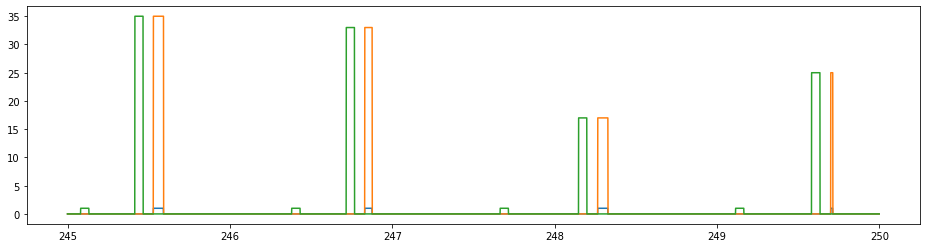

In [34]:
plt.figure(figsize=(16,4))
# Blue line (barely visible): Value of 1 at light sensor timestamps:
plt.plot(raw.times[start:stop], light_sensor_thresholded.T[start:stop])
# Orange line: Light sensor recoded to the stimulus trigger value from stim channel:
plt.plot(raw.times[start:stop], light_sensor_recoded.T[start:stop])
# Green line: The stim channel itself:
trigger_channel_excerpt = raw.get_data(picks='STI101', start=start, stop=stop) - 2048
plt.plot(raw.times[start:stop], trigger_channel_excerpt.T);
# plt.savefig(qc_fname + '_trigger-recode.pdf')

## Loading raw data and adding the new stim channel

In [35]:
np.shape(light_sensor_recoded)

(1, 271000)

In [36]:
np.shape(np.zeros((1, len(raw.times))))

(1, 271000)

In [37]:
stim_raw = mne.io.RawArray(light_sensor_recoded,
                           mne.create_info(['STI'], raw.info['sfreq'], ['stim']))

In [38]:
raw.load_data()  # it is required to load data in memory for adding a channel and subsequent operations

<Raw  |  sub-01_ses-meg_experimental_run-07_proc-sss_raw.fif, n_channels x n_times : 327 x 271000 (271.0 sec), ~681.6 MB, data loaded>

In [39]:
raw.add_channels([stim_raw], force_update_info=True)

<Raw  |  sub-01_ses-meg_experimental_run-07_proc-sss_raw.fif, n_channels x n_times : 328 x 271000 (271.0 sec), ~683.7 MB, data loaded>

The STI101 is the standard stimulus channel, but not time corrected.

MISC001 is the light sensor.

STI is the new stimulus channel that relies on the light sensor time stamp and assigns the value from the STI101.

In [40]:
%matplotlib qt
if interactive:
    raw.plot()

# Dropping channels, resampling, and filtering

In [41]:
to_drop = ['STI001', 'STI002', 'STI003', 'STI004', 'STI005', 'STI006', 'SYS201',  # dropping redundant stim channels
           # head position trackers:
           'CHPI001', 'CHPI002', 'CHPI003', 'CHPI004', 'CHPI005', 'CHPI006', 'CHPI007', 'CHPI008', 'CHPI009',
           'STI101', 'MISC001']  # the old stim channel and the light sensor: their info is now in new channel "STI"
# Head position is accounted for by maxfiltering, so it is no longer necessary
raw.resample(300)
raw.drop_channels(to_drop)

<Raw  |  sub-01_ses-meg_experimental_run-07_proc-sss_raw.fif, n_channels x n_times : 310 x 81300 (271.0 sec), ~197.8 MB, data loaded>

In [42]:
%matplotlib qt
if interactive:
    raw.plot()

In [43]:
raw.filter(filt_low, filt_high)

<Raw  |  sub-01_ses-meg_experimental_run-07_proc-sss_raw.fif, n_channels x n_times : 310 x 81300 (271.0 sec), ~197.8 MB, data loaded>

# Events

## All event IDs

In [44]:
event_id = {
    'left/dur1/cont017': 2, 'left/dur1/cont033': 3, 'left/dur1/cont050': 4, 'left/dur1/cont100': 5,
    'left/dur2/cont017': 6, 'left/dur2/cont033': 7, 'left/dur2/cont050': 8, 'left/dur2/cont100': 9,
    'left/dur3/cont017': 10, 'left/dur3/cont033': 11, 'left/dur3/cont050': 12, 'left/dur3/cont100': 13,
    'left/dur4/cont017': 14, 'left/dur4/cont033': 15, 'left/dur4/cont050': 16, 'left/dur4/cont100': 17,
    'right/dur1/cont017': 22, 'right/dur1/cont033': 23, 'right/dur1/cont050': 24, 'right/dur1/cont100': 25,
    'right/dur2/cont017': 26, 'right/dur2/cont033': 27, 'right/dur2/cont050': 28, 'right/dur2/cont100': 29,
    'right/dur3/cont017': 30, 'right/dur3/cont033': 31, 'right/dur3/cont050': 32, 'right/dur3/cont100': 33,
    'right/dur4/cont017': 34, 'right/dur4/cont033': 35, 'right/dur4/cont050': 36, 'right/dur4/cont100': 37,
}

In [45]:
events = mne.find_events(raw, stim_channel='STI', verbose=True)

193 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37]


To examine the plots labeled with the event IDs:

<ipython-input-46-2059bcffc6ab>:1: RuntimeWarning: event 1 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=event_id)
<ipython-input-46-2059bcffc6ab>:1: RuntimeWarning: More events than colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=event_id)


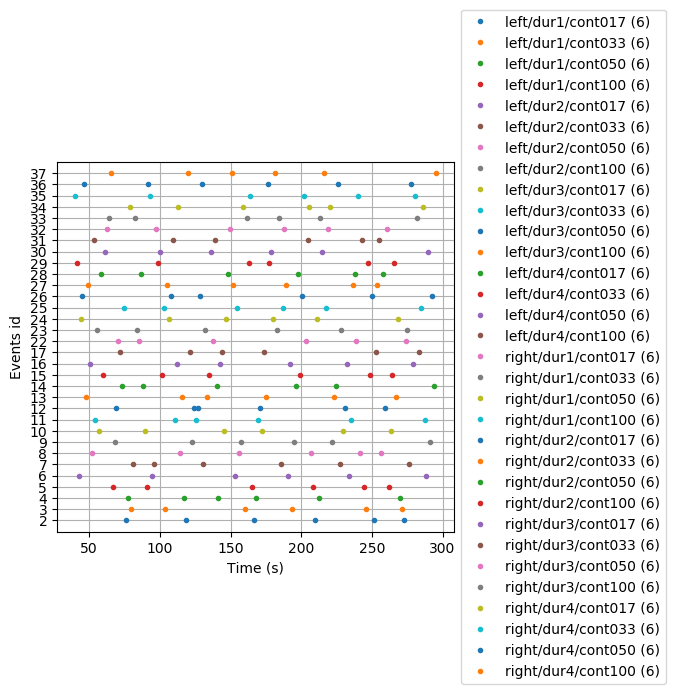

In [46]:
fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=event_id)
fig

In [47]:
%matplotlib qt
if interactive:
    raw.plot(event_id=event_id, events=events)

## Left vs right gratings

<ipython-input-48-94ac49e51885>:4: RuntimeWarning: event 1 missing from event_id will be ignored
  fig = mne.viz.plot_events(events_ori, sfreq=raw.info['sfreq'], event_id=event_id_ori)


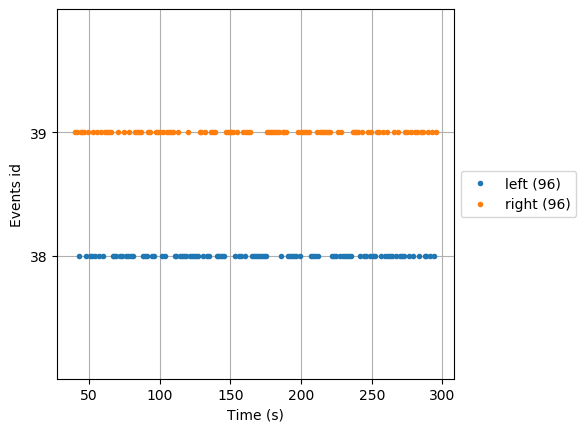

In [48]:
events_ori = mne.merge_events(events, ids=np.arange(2, 18), new_id=38)
events_ori = mne.merge_events(events_ori, ids=np.arange(22, 38), new_id=39)
event_id_ori = {'left': 38, 'right': 39}
fig = mne.viz.plot_events(events_ori, sfreq=raw.info['sfreq'], event_id=event_id_ori)
fig

In [49]:
%matplotlib qt
if interactive:
    raw.plot(event_id=event_id_ori, events=events_ori)

# Epochs

In [50]:
## Pick channels by type and names
picks = mne.pick_types(raw.info, meg=True, eeg=False, eog=True, stim=False, exclude='bads')
epochs = mne.Epochs(raw, events, event_id, epoch_beg_s, epoch_end_s, proj=True,
                    picks=picks, baseline=baseline, reject=reject)

## Dropping bad epochs

In [51]:
epochs

<Epochs  |   192 events (good & bad), -0.3 - 0.6 sec, baseline [-0.2, 0], ~5.5 MB, data not loaded,
 'left/dur1/cont017': 6
 'left/dur1/cont033': 6
 'left/dur1/cont050': 6
 'left/dur1/cont100': 6
 'left/dur2/cont017': 6
 'left/dur2/cont033': 6
 'left/dur2/cont050': 6
 'left/dur2/cont100': 6
 'left/dur3/cont017': 6
 'left/dur3/cont033': 6
 'left/dur3/cont050': 6
 'left/dur3/cont100': 6
 'left/dur4/cont017': 6
 'left/dur4/cont033': 6
 'left/dur4/cont050': 6
 'left/dur4/cont100': 6
 'right/dur1/cont017': 6
 'right/dur1/cont033': 6
 'right/dur1/cont050': 6
 'right/dur1/cont100': 6
 'right/dur2/cont017': 6
 'right/dur2/cont033': 6
 'right/dur2/cont050': 6
 'right/dur2/cont100': 6
 'right/dur3/cont017': 6
 'right/dur3/cont033': 6
 'right/dur3/cont050': 6
 'right/dur3/cont100': 6
 'right/dur4/cont017': 6
 'right/dur4/cont033': 6
 'right/dur4/cont050': 6
 'right/dur4/cont100': 6>

In [52]:
epochs.drop_bad()  # remove bad epochs based on rejection thresholds in <reject> var
epochs.load_data()  # load data in memory

<Epochs  |   136 events (all good), -0.3 - 0.6 sec, baseline [-0.2, 0], ~92.1 MB, data loaded,
 'left/dur1/cont017': 3
 'left/dur1/cont033': 4
 'left/dur1/cont050': 5
 'left/dur1/cont100': 5
 'left/dur2/cont017': 4
 'left/dur2/cont033': 4
 'left/dur2/cont050': 4
 'left/dur2/cont100': 5
 'left/dur3/cont017': 6
 'left/dur3/cont033': 4
 'left/dur3/cont050': 3
 'left/dur3/cont100': 4
 'left/dur4/cont017': 6
 'left/dur4/cont033': 4
 'left/dur4/cont050': 5
 'left/dur4/cont100': 3
 'right/dur1/cont017': 4
 'right/dur1/cont033': 5
 'right/dur1/cont050': 5
 'right/dur1/cont100': 5
 'right/dur2/cont017': 5
 'right/dur2/cont033': 6
 'right/dur2/cont050': 3
 'right/dur2/cont100': 4
 'right/dur3/cont017': 3
 'right/dur3/cont033': 3
 'right/dur3/cont050': 4
 'right/dur3/cont100': 4
 'right/dur4/cont017': 4
 'right/dur4/cont033': 5
 'right/dur4/cont050': 3
 'right/dur4/cont100': 4>

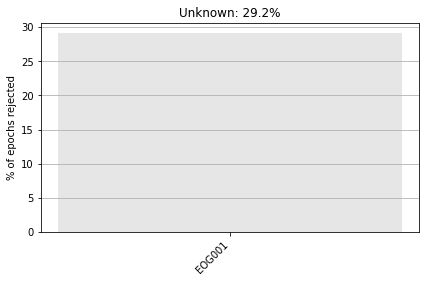

In [53]:
%matplotlib inline
epochs.plot_drop_log();

## Saving epochs to file

In [54]:
raw_fname

'E:\\meg\\derivatives\\meg_derivatives\\sub-01\\ses-meg\\meg\\sub-01_ses-meg_experimental_run-07_proc-sss_raw.fif'

In [55]:
epochs_fname = raw_fname.replace('_raw.fif', '_epo.fif')
epochs_fname

'E:\\meg\\derivatives\\meg_derivatives\\sub-01\\ses-meg\\meg\\sub-01_ses-meg_experimental_run-07_proc-sss_epo.fif'

In [56]:
epochs.save(epochs_fname, overwrite=True)  # note that epochs are save in files ending with -epo.fif

# Evoked

In [57]:
evoked = epochs.average()  # the average of epochs with dropped bads
times = [-.1, .1, .2]

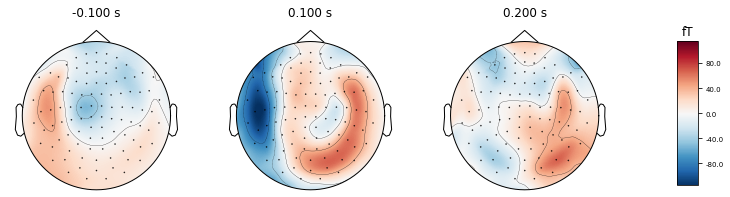

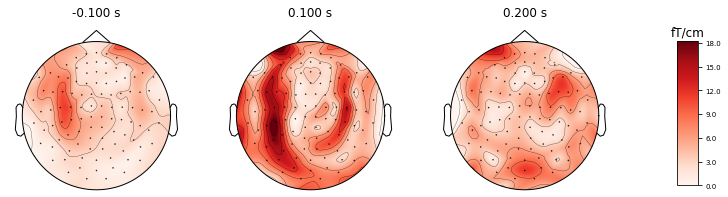

In [58]:
fig = evoked.plot_topomap(ch_type='mag', times=times, proj=True, show=False)
fig.set_size_inches(12, 4)
fig = evoked.plot_topomap(ch_type='grad', times=times, proj=True, show=False)
fig.set_size_inches(12, 4)

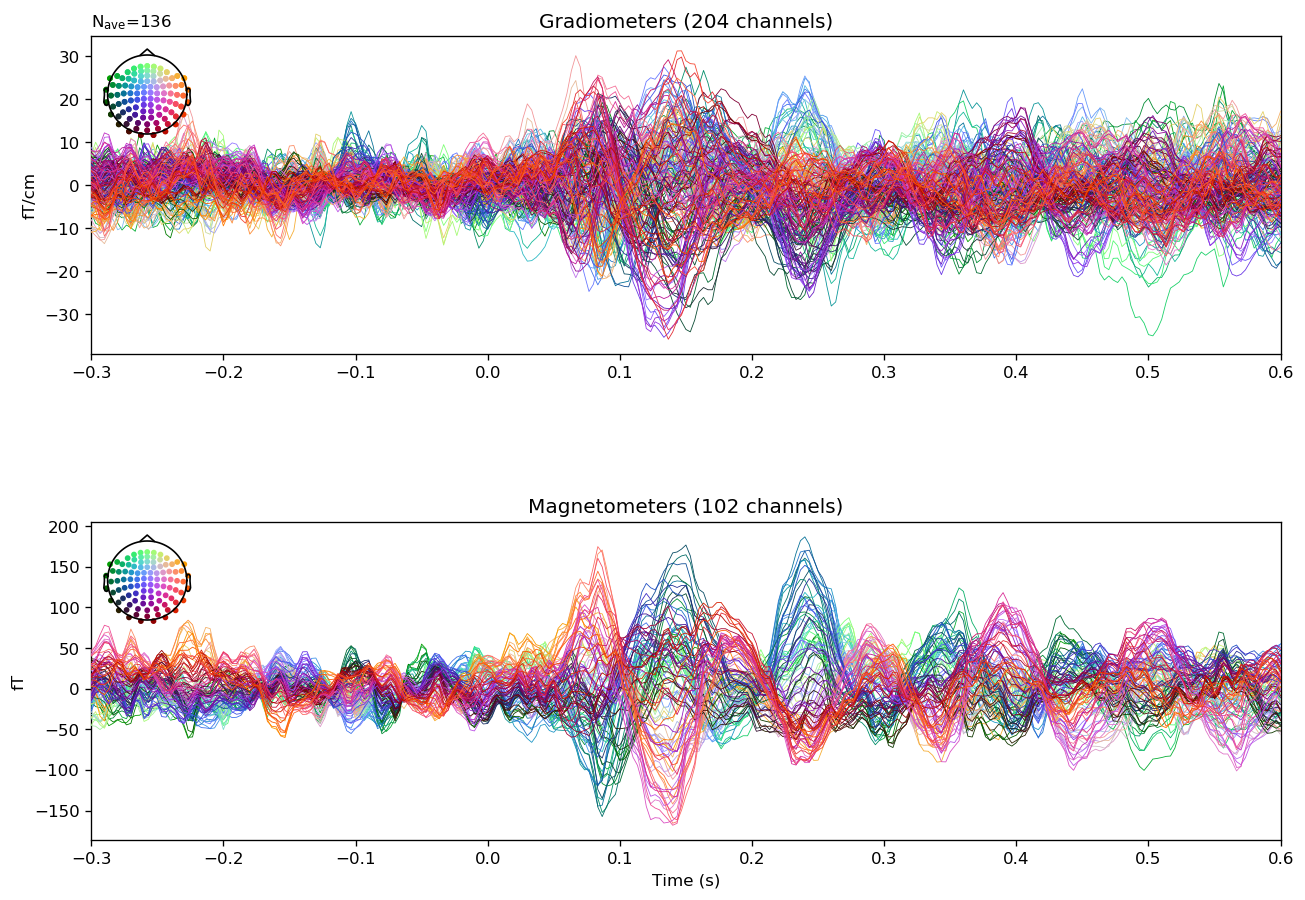

In [59]:
fig = evoked.plot(spatial_colors=True, proj=True, show=False);
fig.set_size_inches(12, 9)
fig.set_dpi(120)
plt.savefig(qc_fname + '_evoked-topo.pdf')

In [60]:
evoked_fname = raw_fname.replace('_raw.fif', '_ave.fif')
evoked_fname

'E:\\meg\\derivatives\\meg_derivatives\\sub-01\\ses-meg\\meg\\sub-01_ses-meg_experimental_run-07_proc-sss_ave.fif'

In [61]:
evoked.save(evoked_fname)  # note that the file for evoked ends with _ave.fif

# P.S.

In [62]:
%matplotlib
%matplotlib qt

Using matplotlib backend: Qt5Agg


In [63]:
interactive = True